# Load Data

In [1]:
# Matplotlib
import matplotlib.pyplot as plt
# Numpy
import numpy as np
# Pillow
from PIL import Image
# Torch
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.optim.lr_scheduler as lr_scheduler
from torchvision import transforms
# from torchsummary import summary
# Misc
import time
from datetime import datetime
# preprocessing 
import av
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt

In [16]:
data_dir = "dataset"
train_dir = f'{data_dir}/train'
val_dir = f'{data_dir}/val'
test_dir = f'{data_dir}/test'

In [17]:
# All training dataset paths

train_path = [os.path.join(train_dir, f) for f in os.listdir(train_dir)]
val_path = [os.path.join(val_dir, f) for f in os.listdir(val_dir)]
test_path = [os.path.join(test_dir, f) for f in os.listdir(test_dir)]

In [18]:
# All labels

train_label_df = pd.read_csv(f'{data_dir}/train_labels.csv', header=None)
test_label_df = pd.read_csv(f'{data_dir}/test_ground_truth.csv', header=None)
val_label_df = pd.read_csv(f'{data_dir}/val_ground_truth.csv', header=None)

# convert all into hashmap - key = u_vid_name , value = label

train_label = {f"{train_dir}/{k[0]}": k[1] for k in train_label_df.values.tolist()}
test_label = {f"{test_dir}/{k[0]}": k[1] for k in test_label_df.values.tolist()}
val_label = {f"{val_dir}/{k[0]}": k[1] for k in val_label_df.values.tolist()}

In [19]:
# Total label + turkish to english translation

total_label = pd.read_csv(f'{data_dir}/SignList_ClassId_TR_EN.csv')
u_len_label = len(total_label['ClassId'].unique())
print("total unique label:", u_len_label)


total unique label: 226


# Preprocessing

In [20]:
# mask rbg image
def masking(rbg_vid, depth_vid):
    """
    input
        - path for rbg
        - path for depth
    output
        - array of numpy arrays
    """
    rbg_arr = []
    container_rbg = av.open(rbg_vid)

    for packet in container_rbg.demux():
        for frame in packet.decode():
            rbg_arr.append(np.array(frame.to_image()))

    depth_arr = []
    container_depth = av.open(depth_vid)

    for packet in container_depth.demux():
        for frame in packet.decode():
            depth_arr.append(np.array(frame.to_image()))

    # display - correct color orientation
    overlay_arr = []
    for i in range(len(rbg_arr)):
        c = cv2.cvtColor(rbg_arr[i], cv2.COLOR_BGR2RGB)

        gray = cv2.cvtColor(depth_arr[i], cv2.COLOR_BGR2GRAY)
        overlay = cv2.bitwise_and(c,c, mask= gray)
        overlay_arr.append(overlay)
        
    return np.array(overlay_arr)

# Custom Dataset

In [21]:
class Turkish_Dataset(Dataset):
    def __init__(self, paths, labels):
        self.paths = paths
        self.labels = labels
        self._get_unique()
        
    def _get_unique(self):
        u_vid_depth = {}
        u_vid_color = {}
        u_vid = set()
        for path in self.paths:
            vid = path.split("\\")[-1].split(".")[0] # train\\signer0_sample1_color.mp4 or train\\signer0_sample1_depth.mp4
            vid_split = vid.split("_")
            vid_type = vid_split[-1] # color or depth
            vid_name = "_".join(vid_split[:-1]) # signer0_sample1_color
            if vid_type == "color":
                u_vid_color[vid_name] = path
            elif vid_type == "depth":
                u_vid_depth[vid_name] = path
            else:
                raise ValueError('Detected vid type as neither color nor depth. type is', vid_type)
            u_vid.add(vid_name)
        self.u_vid_depth = u_vid_depth
        self.u_vid_color = u_vid_color
        self.u_vid = list(u_vid)
    
    def __getitem__(self, index):
        vid_name = self.u_vid[index]
        vid_label = self.labels[vid_name]
        
        vid_color = self.u_vid_color[vid_name]
        vid_depth = self.u_vid_depth[vid_name]
        
        # preprocessing
        vid_arr = masking(vid_color, vid_depth)
        
        # create one-hot-encoding for label
        label = np.zeros(u_len_label)
        label[vid_label] = 1
        
        # convert arr to tensors
        vid_arr = torch.from_numpy(vid_arr).float()
        label = torch.from_numpy(label).float()
        
        # return masked video array and label
        return vid_arr, label
                
    
    def __len__(self):
        return len(self.u_vid)

shape of first array torch.Size([59, 512, 512, 3])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


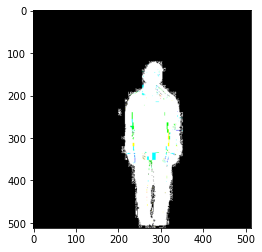

In [22]:
# Create train dataset

ld_train = Turkish_Dataset(train_path, train_label)
print("shape of first array", ld_train[0][0].shape)

# show image but clip rbg values
plt.imshow(ld_train[0][0][0])
plt.show()

shape of first array torch.Size([59, 512, 512, 3])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


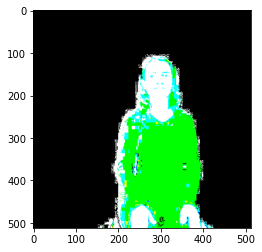

In [23]:
# Create test dataset

ld_test = Turkish_Dataset(test_path, test_label)
print("shape of first array", ld_test[0][0].shape)

# show image but clip rbg values
plt.imshow(ld_test[0][0][0])
plt.show()

shape of first array torch.Size([57, 512, 512, 3])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


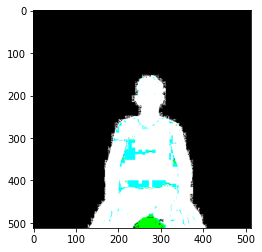

In [24]:
# Create val dataset

ld_val = Turkish_Dataset(val_path, val_label)
print("shape of first array", ld_val[0][0].shape)

# show image but clip rbg values
plt.imshow(ld_val[0][0][0])
plt.show()

# Custom Dataloader

In [34]:
bs_train = 1
bs_test = 1
bs_val = 1
train_loader = DataLoader(ld_train, batch_size = bs_train, shuffle = True)
test_loader = DataLoader(ld_test, batch_size = bs_test, shuffle = True)
val_loader = DataLoader(ld_val, batch_size = bs_val, shuffle = True)

In [35]:
for batch_idx, (images_data, target_labels) in enumerate(train_loader):
    print(batch_idx)
    print(images_data.shape)
    print(target_labels.shape)
    if batch_idx >5:
        break

0
torch.Size([1, 67, 512, 512, 3])
torch.Size([1, 226])
1
torch.Size([1, 64, 512, 512, 3])
torch.Size([1, 226])
2
torch.Size([1, 67, 512, 512, 3])
torch.Size([1, 226])
3
torch.Size([1, 50, 512, 512, 3])
torch.Size([1, 226])
4
torch.Size([1, 54, 512, 512, 3])
torch.Size([1, 226])
5
torch.Size([1, 63, 512, 512, 3])
torch.Size([1, 226])
6
torch.Size([1, 61, 512, 512, 3])
torch.Size([1, 226])


# Architecture

In [36]:
from models import CNN_RNN

In [ ]:
model = CNN_RNN()

# Training

# Graph